## Image segmentation with CamVid

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

Untar the camvid data.

Set two paths: one to the labels at `path_lbl` and one to the images at `path_img`.

## Data

Get the image files using `get_image_files`. Print the first three.

Get the label image files also using `get_image_files`. Print the first three.

Show the first image.

Observe the image names and labels. Write a function that converts a given image name into its corresponding label name.

Use `open_mask` on the mask image name, and show it with the `show` method.

Create a variable called `src_size` with the length and width values of the mask. Print that along with actual mask data values.

Use `np.loadtxt` to load the text values from `path/'codes.txt'`.

## Datasets

Set size to `src_size//2`. Set `bs = 4`. 

Create a `SegmentationItemList` from folder `path_img`, split by fname file `../valid.txt`, label from func `get_y_fn` with `classes=codes`.

Turn that into a databunch with standard transforms, `size=size`, `tfm_y=True`, `bs=bs`, and normalize using imagenet stats.

Show a 2x2 batch with figsize 10,7 on the training set.

Same but validation set.

## Model

In [19]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [20]:
metrics=acc_camvid
# metrics=accuracy

In [21]:
wd=1e-2

In [22]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


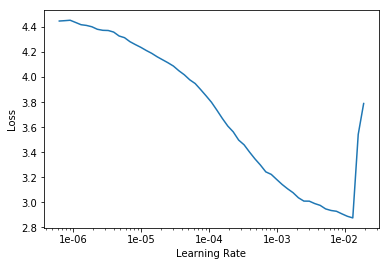

In [23]:
lr_find(learn)
learn.recorder.plot()

In [24]:
lr=3e-3

In [ ]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid,time
1,0.939749,0.791710,0.796229,02:58
2,0.743643,0.605062,0.845449,02:52
3,0.633388,0.501141,0.869665,02:52


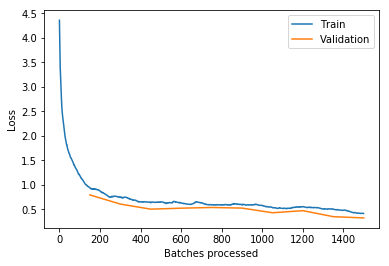

In [27]:
learn.recorder.plot_losses()

In [26]:
learn.save('stage-1')

In [28]:
learn.load('stage-1');

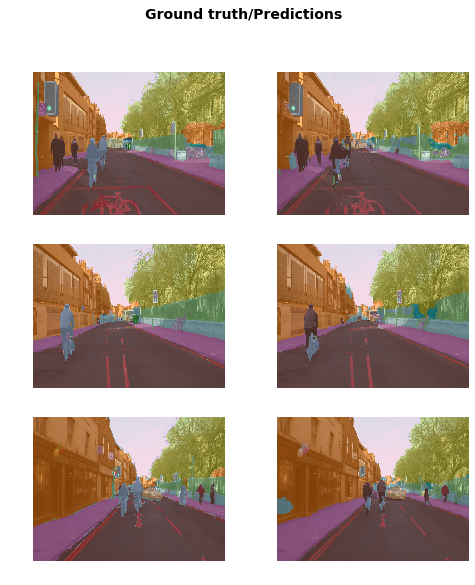

In [29]:
learn.show_results(rows=3, figsize=(8,9))

In [30]:
learn.unfreeze()

In [31]:
lrs = slice(lr/400,lr/4)

In [32]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
1,0.378219,0.311461,0.908407,03:02
2,0.364995,0.302888,0.911853,03:00
3,0.357481,0.307424,0.911013,03:00
4,0.348994,0.286438,0.918360,03:00
5,0.342609,0.288675,0.921952,03:00
6,0.316073,0.286954,0.919403,03:01
7,0.335801,0.278394,0.922313,03:01
8,0.323229,0.283774,0.919128,03:01
9,0.333629,0.283653,0.923835,03:00
10,0.313342,0.293008,0.921565,03:00


In [33]:
learn.save('stage-2');

## Go big

You may have to restart your kernel and come back to this stage if you run out of memory, and may also need to decrease `bs`.

In [ ]:
#learn.destroy() # uncomment once 1.0.46 is out

size = src_size

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=3
else:           bs=1
print(f"using bs={bs}, have {free}MB of GPU RAM free")

In [ ]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [ ]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [ ]:
learn.load('stage-2');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


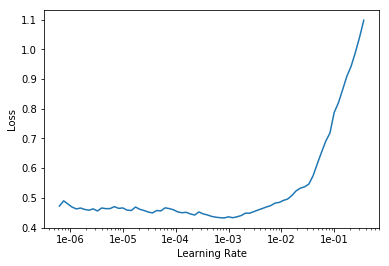

In [ ]:
lr_find(learn)
learn.recorder.plot()

In [ ]:
lr=1e-3

In [ ]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid
1,0.366140,0.339497,0.908682
2,0.333278,0.304011,0.916702
3,0.326025,0.305404,0.919941
4,0.336885,0.321342,0.910933
5,0.326935,0.305589,0.919401
6,0.347779,0.333608,0.908895
7,0.328334,0.352358,0.905482
8,0.327277,0.387525,0.912187
9,0.291777,0.293065,0.918046
10,0.228348,0.257859,0.929750


In [ ]:
learn.save('stage-1-big')

In [ ]:
learn.load('stage-1-big');

In [ ]:
learn.unfreeze()

In [ ]:
lrs = slice(1e-6,lr/10)

In [ ]:
learn.fit_one_cycle(10, lrs)

epoch,train_loss,valid_loss,acc_camvid
1,0.225999,0.254650,0.930782
2,0.216341,0.256007,0.930751
3,0.209800,0.255649,0.930709
4,0.203509,0.252857,0.931682
5,0.202308,0.258498,0.931308
6,0.200796,0.257311,0.931915
7,0.204560,0.251486,0.933218
8,0.192893,0.254977,0.932786
9,0.189505,0.258091,0.932555
10,0.190156,0.256064,0.933315


In [ ]:
learn.save('stage-2-big')

In [ ]:
learn.load('stage-2-big');

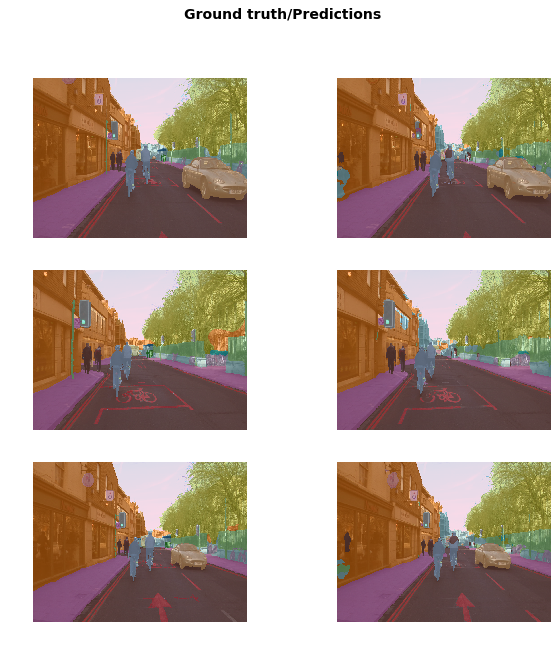

In [ ]:
learn.show_results(rows=3, figsize=(10,10))

## fin